### simplified self-attention

Introduced to find links between input tokens.  
  
Calculation of context vectors from input embedding:  
    i/p embedding --> attention score (dot product) --> attention weights (softmax normalization) --> context vectors (attention weighted sum)

In [3]:
import torch

# example sentence: Dream big and work for it
sen = "Dream big and work for it"

inputs = torch.tensor(
    [[0.72, 0.45, 0.31], #Dream  (x^1)
    [0.75, 0.20, 0.55], #big    (x^2)
    [0.30, 0.80, 0.40], #and    (x^3)
    [0.85, 0.35, 0.60], #work   (x^4)
    [0.55, 0.15, 0.75], #for    (x^5)
    [0.25, 0.20, 0.85]] #it     (x^6)
)

#corresponding words
words = sen.split()
words

['Dream', 'big', 'and', 'work', 'for', 'it']

In [4]:
#magnitude of each vector
magnitudes = torch.norm(inputs, dim=1)

for word, mag in zip(words, magnitudes):
    print(f"{word}: {mag.item():.4f}")

Dream: 0.9039
big: 0.9513
and: 0.9434
work: 1.0977
for: 0.9421
it: 0.9083


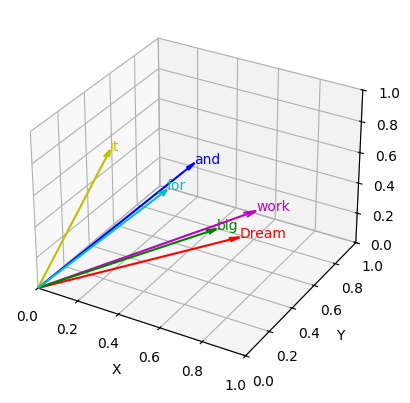

In [8]:
#plotting 3D vector
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#extract x,y,z coordinates
x_c = inputs[:, 0].numpy()
y_c = inputs[:, 1].numpy()
z_c = inputs[:, 2].numpy()

#3D plot vectors from origin
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = list('rgbmcy')

for (x,y,z,wrd,clr) in zip(x_c,y_c,z_c,words,colors):
    ax.quiver(0, 0, 0, x, y, z, color=clr, arrow_length_ratio=0.05)
    ax.text(x, y, z, wrd, fontsize=10, color=clr)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
plt.show()

In [9]:
#attention scores (dot product between each embedding)
attn_scr = inputs @ inputs.T
attn_scr

tensor([[0.8170, 0.8005, 0.7000, 0.9555, 0.6960, 0.5335],
        [0.8005, 0.9050, 0.6050, 1.0375, 0.8550, 0.6950],
        [0.7000, 0.6050, 0.8900, 0.7750, 0.5850, 0.5750],
        [0.9555, 1.0375, 0.7750, 1.2050, 0.9700, 0.7925],
        [0.6960, 0.8550, 0.5850, 0.9700, 0.8875, 0.8050],
        [0.5335, 0.6950, 0.5750, 0.7925, 0.8050, 0.8250]])

In [11]:
#attention weight (softmax)
attn_wts = torch.softmax(attn_scr, dim=1) #converts each score to probabilistic value
print(attn_wts)
print(attn_wts.sum(dim=1)) #sum of each row is 1

tensor([[0.1766, 0.1738, 0.1571, 0.2029, 0.1565, 0.1330],
        [0.1624, 0.1803, 0.1336, 0.2059, 0.1715, 0.1462],
        [0.1675, 0.1523, 0.2025, 0.1805, 0.1493, 0.1478],
        [0.1648, 0.1789, 0.1376, 0.2115, 0.1672, 0.1400],
        [0.1491, 0.1747, 0.1334, 0.1960, 0.1805, 0.1662],
        [0.1396, 0.1641, 0.1455, 0.1809, 0.1831, 0.1868]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [ ]:
#context vectors
context_vec = attn_wts @ inputs
context_vec

tensor([[0.5965, 0.3611, 0.5654],
        [0.5982, 0.3431, 0.5794],
        [0.5681, 0.3830, 0.5627],
        [0.6008, 0.3471, 0.5758],
        [0.5859, 0.3377, 0.5900],
        [0.5684, 0.3402, 0.5964]])

: 

### self-attention with trainable weights

Simplified self-attention failed to capture verb-subject relationship. Therefore, the concept of query, key and value was introduced which could be learned during training. These help to transform the input embedding to make it context rich.

Context vector calculation procedure:  
i/p embedding --> W_q, W_k, W_v each multipled with i/p embedd to get Q, K, V respectively --> Q.K^T to get attention scores --> attention score scaled --> softmax for attention weights --> context vector (attention weighted sum of transformed inputs)

In [ ]:
import torch

# example sentence: Dream big and work for it
sen = "Dream big and work for it"

inputs = torch.tensor(
    [[0.72, 0.45, 0.31],    #Dream  (x^1)
    [0.75, 0.20, 0.55],     #big    (x^2)
    [0.30, 0.80, 0.40],     #and    (x^3)
    [0.85, 0.35, 0.60],     #work   (x^4)
    [0.55, 0.15, 0.75],     #for    (x^5)
    [0.25, 0.20, 0.85]]     #it     (x^6)
)
print(inputs.shape)

#corresponding words
words = sen.split()
words

torch.Size([6, 3])


['Dream', 'big', 'and', 'work', 'for', 'it']

In [5]:
d_in = inputs.shape[1]      # dimension of each input token
d_out = 2                   # dimension of the context vectors (here we are reducing the dimension but in general dimension remains the same)
print(d_in)

3


In [ ]:
# randomly initializing W_q, W_k, W_v each of size (3, 2)
torch.manual_seed(123)      # It forces PyTorch's random number generator (RNG) to start from the same state every time. No matter how many time you run this cell, it will produce the same output.
W_q = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_k = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_v = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

print(W_q)
print(W_k)
print(W_v)

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])
Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])
Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


In [8]:
# checking how Q, K, V is created for one token (x^2) 
x_2 = inputs[1]
print(x_2)
q = x_2 @ W_q
print(q)
k = x_2 @ W_k
print(k)
v = x_2 @ W_v
print(v) 

tensor([0.7500, 0.2000, 0.5500])
tensor([0.3131, 1.0017])
tensor([0.3126, 0.6001])
tensor([0.1852, 0.6829])


In [ ]:
# for all tokens, each of shape (6, 3) x (3, 2) --> (6, 2)
queries = inputs @ W_q
keys = inputs @ W_k
values = inputs @ W_v
print(queries)
print(keys)
print(values)

tensor([[0.3494, 0.9504],
        [0.3131, 1.0017],
        [0.3198, 1.0524],
        [0.3842, 1.2000],
        [0.2561, 1.0373],
        [0.1872, 1.0034]])
tensor([[0.2789, 0.6137],
        [0.3126, 0.6001],
        [0.3143, 0.8867],
        [0.3697, 0.7536],
        [0.3392, 0.6807],
        [0.3389, 0.7549]])
tensor([[0.2336, 0.5789],
        [0.1852, 0.6829],
        [0.3232, 0.7113],
        [0.2462, 0.8042],
        [0.1780, 0.7890],
        [0.1830, 0.8328]])


In [10]:
# attention score Q.K^T of shape (6, 2) x (2, 6) --> (6, 6)
attn_scr = queries @ keys.T
print(attn_scr)

tensor([[0.6807, 0.6795, 0.9526, 0.8454, 0.7654, 0.8359],
        [0.7021, 0.6990, 0.9867, 0.8707, 0.7880, 0.8624],
        [0.7350, 0.7315, 1.0337, 0.9113, 0.8248, 0.9029],
        [0.8436, 0.8402, 1.1848, 1.0464, 0.9471, 1.0361],
        [0.7080, 0.7025, 1.0003, 0.8764, 0.7929, 0.8699],
        [0.6680, 0.6606, 0.9486, 0.8254, 0.7465, 0.8210]])


In [11]:
# scaling the attention score (by multiplying each value by 1/sqt(d))
d_k = keys.shape[-1]
attn_scr_scaled = attn_scr / d_k**0.5
print(attn_scr_scaled)

tensor([[0.4813, 0.4805, 0.6736, 0.5978, 0.5412, 0.5911],
        [0.4964, 0.4943, 0.6977, 0.6157, 0.5572, 0.6098],
        [0.5198, 0.5172, 0.7310, 0.6444, 0.5832, 0.6384],
        [0.5965, 0.5941, 0.8378, 0.7399, 0.6697, 0.7327],
        [0.5006, 0.4967, 0.7073, 0.6197, 0.5607, 0.6151],
        [0.4723, 0.4671, 0.6708, 0.5836, 0.5278, 0.5805]])


In [13]:
# attention weights using softmax
attn_wts = torch.softmax(attn_scr_scaled, dim=-1)
print(attn_wts) 
print(attn_wts.sum(dim=1))

tensor([[0.1536, 0.1534, 0.1861, 0.1725, 0.1630, 0.1714],
        [0.1531, 0.1528, 0.1873, 0.1725, 0.1627, 0.1715],
        [0.1525, 0.1521, 0.1884, 0.1728, 0.1625, 0.1717],
        [0.1505, 0.1501, 0.1915, 0.1737, 0.1619, 0.1724],
        [0.1530, 0.1524, 0.1881, 0.1724, 0.1625, 0.1716],
        [0.1538, 0.1530, 0.1875, 0.1719, 0.1625, 0.1713]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [14]:
# getting context vector attn_wts.values of shape (6, 6) x (6, 2) --> (6, 2)
context_vec = attn_wts @ values
print(context_vec)

tensor([[0.2273, 0.7361],
        [0.2274, 0.7362],
        [0.2276, 0.7363],
        [0.2280, 0.7368],
        [0.2275, 0.7362],
        [0.2275, 0.7360]])


In [15]:
# new context rich vectors
for wrd, emb in zip(words, context_vec):
    print(f"{wrd}: {emb}")

Dream: tensor([0.2273, 0.7361])
big: tensor([0.2274, 0.7362])
and: tensor([0.2276, 0.7363])
work: tensor([0.2280, 0.7368])
for: tensor([0.2275, 0.7362])
it: tensor([0.2275, 0.7360])


In [17]:
# converting the entire code into python class
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_q = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
        self.W_k = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
        self.W_v = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

    def forward(self, x): # x==inputs
        queries = x @ self.W_q
        keys = x @ self.W_k
        values = x @ self.W_v

        attn_scores = queries @ keys.T
        att_weights = torch.softmax(
                attn_scores / keys.shape[-1]**0.5, dim=-1 
            )
        
        context_vector = att_weights @ values
        return context_vector



In [ ]:
torch.manual_seed(123) 
sa_v1 = SelfAttention_v1(d_in=inputs.shape[1], d_out=3)
print(sa_v1(inputs))

tensor([[0.5904, 0.9922, 1.0056],
        [0.5902, 0.9906, 1.0046],
        [0.5902, 0.9936, 1.0058],
        [0.5906, 0.9926, 1.0062],
        [0.5899, 0.9896, 1.0036],
        [0.5895, 0.9889, 1.0025]])


### causal attention

Self-attention was good for encoder-based models like BERT. But for generative models like GPT, it required some modifications in order to avoid data-leakage. Causal attention enforces a temporal or causal structure, where the output at time t depends only on previous tokens(causes) and not future tokens(effects).  

Steps are same as trainable weights with an addition of two more formatting:  
--> masking  
--> dropout  

In [20]:
import torch

# example sentence: Dream big and work for it
sen = "Dream big and work for it"

inputs = torch.tensor(
    [[0.72, 0.45, 0.31],    #Dream  (x^1)
    [0.75, 0.20, 0.55],     #big    (x^2)
    [0.30, 0.80, 0.40],     #and    (x^3)
    [0.85, 0.35, 0.60],     #work   (x^4)
    [0.55, 0.15, 0.75],     #for    (x^5)
    [0.25, 0.20, 0.85]]     #it     (x^6)
)
print(inputs.shape)

#corresponding words
words = sen.split()
words

torch.Size([6, 3])


['Dream', 'big', 'and', 'work', 'for', 'it']

In [ ]:
import torch.nn as nn

class MaskedAttention(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_q = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
        self.W_k = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
        self.W_v = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)       

    def forward(self, x): # x==inputs
        queries = x @ self.W_q
        keys = x @ self.W_k
        values = x @ self.W_v

        attn_scores = queries @ keys.T
        print(f"Attention score (before masking):\n {attn_scores}")

        #masking
        new_attn_score = self.masking(attn_scores, x.shape[0])

        att_weights = torch.softmax(
                new_attn_score / keys.shape[-1]**0.5, dim=-1 
            )
        
        print(f"Attention weights:\n {att_weights}")

        #dropout
        new_attn_wts = self.dropout(att_weights, x.shape[0])
       
        context_vector = new_attn_wts @ values
        return context_vector
    
    def masking(self, attn_scr, context_len):
        #masking
        mask = torch.triu(torch.ones(context_len, context_len), diagonal=1)
        masked_attn = attn_scr.masked_fill(mask.bool(), -torch.inf)
        print(f"Attention score (after masking):\n {masked_attn}")

        return masked_attn
    
    def dropout(self, att_wts, context_len):
        torch.manual_seed(123)
        dropout = torch.nn.Dropout(0.5)
        drop_attn_wts = dropout(att_wts)
        print(f"Dropped values:\n {drop_attn_wts}")

        return drop_attn_wts


In [31]:
torch.manual_seed(123) 
sa_v1 = MaskedAttention(d_in=inputs.shape[1], d_out=2)
print(sa_v1(inputs))

Attention score (before masking):
 tensor([[0.6807, 0.6795, 0.9526, 0.8454, 0.7654, 0.8359],
        [0.7021, 0.6990, 0.9867, 0.8707, 0.7880, 0.8624],
        [0.7350, 0.7315, 1.0337, 0.9113, 0.8248, 0.9029],
        [0.8436, 0.8402, 1.1848, 1.0464, 0.9471, 1.0361],
        [0.7080, 0.7025, 1.0003, 0.8764, 0.7929, 0.8699],
        [0.6680, 0.6606, 0.9486, 0.8254, 0.7465, 0.8210]])
Attention score (after masking):
 tensor([[0.6807,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.7021, 0.6990,   -inf,   -inf,   -inf,   -inf],
        [0.7350, 0.7315, 1.0337,   -inf,   -inf,   -inf],
        [0.8436, 0.8402, 1.1848, 1.0464,   -inf,   -inf],
        [0.7080, 0.7025, 1.0003, 0.8764, 0.7929,   -inf],
        [0.6680, 0.6606, 0.9486, 0.8254, 0.7465, 0.8210]])
Attention weights:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5005, 0.4995, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3093, 0.3086, 0.3821, 0.0000, 0.0000, 0.0000],
        [0.2260, 0.2255, 0.2877, 0.2609

### multi-headed attention

Multiple attention blocks are stacked and work in parallel.

In [ ]:
import torch.nn as nn

class MultiHeadedAttention(nn.Module):

    def __init__(self, d_in, d_out, context_len, dropout, num_heads, batch_size, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.batch_size = batch_size
        # for given example, each W_q, W_k, W_v, will be of (6, 6)
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)               # directly creates weight matrices 
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)               # directly creates weight matrices 
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)               # directly creates weight matrices 
        self.out_proj = nn.Linear(d_in, d_out)                         # linear layer to combine head outputs
        self.dropouts = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_len, context_len), diagonal=1)
        )

    def forward(self, x): # x==inputs

        # each of shape (batch_size, num_tokens, d_out) --> (1, 3, 6)
        queries = self.W_q(x)
        keys = self.W_k(x)
        values = self.W_v(x)
        print(f"Q, K, V shape before: {queries.shape}")

        # unroll Q, K, V by splitting d_out into num_heads, dim of each head
        # (1, 3, 6) --> (1, 3, 2, 3)
        queries = queries.view(self.batch_size, x.shape[1], self.num_heads, self.head_dim)
        keys = keys.view(self.batch_size, x.shape[1], self.num_heads, self.head_dim)
        values = values.view(self.batch_size, x.shape[1], self.num_heads, self.head_dim)
        print(f"Q, K, V shape after unrolling: {queries.shape}")
        print(f"Q before grouping: \n {queries}")

        #grouping based on attention heads instead of tokens by taking transpose between dim 1 and 2
        # (1, 3, 2, 3) --> (1,2,3,3)
        queries = queries.transpose(1,2)
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        print(f"Q after grouping: \n {queries}")

        #attention scores
        #(batch_size, num_heads, num_tokens, head_dim) . (batch_size, num_heads, head_dim, num_tokens) ---> (batch_size, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(2,3)
        print(f"Attention score (before masking):\n {attn_scores}")

        #masking
        # original mask truncated to no of tokens and converted to bool
        mask_bool = self.mask.bool()[:x.shape[1], :x.shape[1]]
        #using mask to fill attention sscores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        print(f"Attention score (after masking):\n {attn_scores}")

        att_weights = torch.softmax(
                attn_scores / keys.shape[-1]**0.5, dim=-1 
            )
        
        print(f"Attention weights:\n {att_weights}")

        #dropout and normalization after dropout
        new_attn_wts = self.dropouts(att_weights)
        print(f"Attention weights (after dropout):\n {new_attn_wts}")
       
        #context vector calculation and transpose to get back (1, 3, 2, 3)
        context_vector = (new_attn_wts @ values).transpose(1,2)

        #combining heads
        context_vec = context_vector.contiguous().view(self.batch_size, x.shape[1], self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec
    


In [2]:
import torch 

inputs = torch.tensor(
    [[0.62, 0.35, 0.35, 0.21, 0.44, 0.52],    #The        (x^1)
    [0.75, 0.20, 0.55, 0.61, 0.23, 0.71],     #kid        (x^2)
    [0.30, 0.80, 0.40, 0.66, 0.21, 0.19]]     #smiles     (x^3)
)
print(inputs.shape)

batch = torch.stack((inputs,), dim=0)
print(batch.shape)

torch.Size([3, 6])
torch.Size([1, 3, 6])


In [15]:
torch.manual_seed(123)

batch_size, context_len, d_in = batch.shape
d_out = 6
num_heads=2
mutli = MultiHeadedAttention(d_in=d_in, 
                             d_out=d_out,
                             context_len=batch.shape[1],
                             dropout=0.1,
                             num_heads=num_heads,
                             batch_size=batch_size)
print(mutli(batch))

Q, K, V shape before: torch.Size([1, 3, 6])
Q, K, V shape after unrolling: torch.Size([1, 3, 2, 3])
Q before grouping: 
 tensor([[[[-0.1346, -0.3360, -0.3689],
          [ 0.3572, -0.1235,  0.5032]],

         [[-0.0073, -0.2428, -0.3226],
          [ 0.4646, -0.2264,  0.5405]],

         [[-0.0348, -0.3325, -0.4296],
          [ 0.3399,  0.1651,  0.5036]]]], grad_fn=<ViewBackward0>)
Q after grouping: 
 tensor([[[[-0.1346, -0.3360, -0.3689],
          [-0.0073, -0.2428, -0.3226],
          [-0.0348, -0.3325, -0.4296]],

         [[ 0.3572, -0.1235,  0.5032],
          [ 0.4646, -0.2264,  0.5405],
          [ 0.3399,  0.1651,  0.5036]]]], grad_fn=<TransposeBackward0>)
Attention score (before masking):
 tensor([[[[-0.1566, -0.1613, -0.2264],
          [-0.1863, -0.2034, -0.2219],
          [-0.2366, -0.2565, -0.2894]],

         [[-0.0529, -0.0223, -0.0664],
          [-0.0754, -0.0187, -0.0841],
          [-0.0752, -0.1012, -0.0845]]]], grad_fn=<UnsafeViewBackward0>)
Attention score (af